<font size=7> Latencies Analysis

In [5]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,\
                                  plot_latency_dist_hist, plot_latency_angle_hist
from human_hip.animate import animate_latencies

In [6]:
with open("/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl", "rb") as filename:
    sd = pickle.load(filename)

In [7]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt

In [12]:
#https://medium.com/@dreamferus/how-to-synchronize-time-series-using-cross-correlation-in-python-4c1fd5668c7a#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImM3ZTExNDEwNTlhMTliMjE4MjA5YmM1YWY3YTgxYTcyMGUzOWI1MDAiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDI5NDUwNDY4Mjk4NDg1MzY1NjYiLCJoZCI6InVjc2MuZWR1IiwiZW1haWwiOiJtZWxsaW90MUB1Y3NjLmVkdSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJuYmYiOjE2OTM1MTg3MjksIm5hbWUiOiJNYXR0IEVsbGlvdHQiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUFjSFR0ZWRoeVRrWk1hU1hJRTFqa1hhZEVmbmhxc3NwNW1lVFkzUHV0THluMVJ1TXc9czk2LWMiLCJnaXZlbl9uYW1lIjoiTWF0dCIsImZhbWlseV9uYW1lIjoiRWxsaW90dCIsImxvY2FsZSI6ImVuIiwiaWF0IjoxNjkzNTE5MDI5LCJleHAiOjE2OTM1MjI2MjksImp0aSI6Ijc5NGMxOTk1NmI5NDJiNWQzNGIzODc0YTdjYzQ1ZTgyZTlkNjdjZTYifQ.mrDH7b9_D0YfYF3xxqJl-Kh5w_XeWgpyntt19-Bvs4VJJpuJR5DRRJsSGO52guE8jSdYsSDS_ILzPyY_rZAyivCZ4mXJv3CftxbNxgxRD_feS8BNI3YPbTh2Oin7tj32Gzm75Nq4k-UnhQxy9d7qVlw29DA6Wns1yTY0B6cb0pPEuKMWfHmlmCUEtDEDX0dE__pUGkBxWwickpa2n-pW-Z71y-hatFAn80JrOPclPZj1Yts9xeV9uPC7ICWTjSVLZB4Nl8mKy6Rxn6pB_ny01ne06iAoYidx2SwRU3j5BVZF1CK-bhVqQ-qOuzIPj17qvkFE9RJT9Zw842YN9f16MA
def cross_correlation_max_shift(x, y):
    correlations = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
    return lags[np.argmax(correlations)]


def curate_latencies(sd, cross_sttc_min_cutoff=2, cross_sttc_max_cutoff=30, sttc_cutoff = 0.04, latency_cutoff=2.5, sigma=45, sttc_delta=20 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  #latency= np.median(pair_latencies)
        if abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
        #if stats.ttest_1samp(pair_latencies,0)[1]<.1 and len(pair_latencies)>25:
            #pairs_late.append( pair )  #lags_late.append( latency )
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=cross_sttc_max_cutoff) 
                if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>25:
                    #print("original pair: ", pair)
                    #print("added pair: ", [ pair[1], pair[0] ])
                    pairs_late.append( [ pair[1], pair[0] ] )   #lags_late.append( latency )
            else:
                pairs_late.append( pair ) 
    #pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")


    # Do cross sttc for all pairs
    print("Starting cross correlation calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs_late: 
        x = np.around( sd.train[pair[0]] ).astype(int)
        y= np.around( sd.train[pair[1]] ).astype(int)
        x_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
        y_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
        x_long[ x ] = 1
        y_long[ y ] = 1
        x_smooth = gaussian_filter(x_long, sigma=sigma) # sigma=15
        y_smooth = gaussian_filter(y_long, sigma=sigma) # sigma=15
        cross_lag.append( cross_correlation_max_shift( x_smooth, y_smooth ) ) 
    
    cross_lag = np.array(cross_lag)
    to_keep = np.where(( cross_lag< cross_sttc_max_cutoff) & (cross_lag> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")
    
    pairs_final = []
    for i in to_keep:
        pairs_final.append(pairs_late[i])

    mean_latencies = []
    for pair in pairs_final:
        mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  )
        mean_latencies.append(mean_latency)
    print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))
    #good_pairs =   np.array(pairs_final)

    return  pairs_final




<font color="brown"> test method

In [13]:
good_pairs = curate_latencies(sd)
# with open( 'hc328_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
##load pickled data
# with open( 'hc328_good_pairs.pkl' , 'rb') as my_file:
#     good_pairs = pickle.load(my_file)
# len(good_pairs)


18496 Starting Pairs
567 pairs above sttc cutoff
107 pairs above latencency cutoff
Starting cross correlation calculation... might take a minute
10 pairs between cross_sttc cutoffs
all final pairs positive?: True


In [22]:
good_pairs2 = np.array(good_pairs)

<font color="red"> We save curated latency pairs because above calculation took over 1 minute

In [14]:
#good_pairs = curate_latencies(sd)
# good_pairs = curate_latencies(sd)
# with open( 'hc328_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
# load pickled data
# with open( 'hc328_good_pairs.pkl' , 'rb') as my_file:
#     good_pairs = pickle.load(my_file)

In [15]:
pair=[0,4]

In [16]:
sd.length/1000/60

6.420634166666667

In [17]:
x = np.around( sd.train[0] ).astype(int)
y= np.around( sd.train[4] ).astype(int)
x_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
y_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
x_long[ x ] = 1
y_long[ y ] = 1
x_smooth = gaussian_filter(x_long, sigma=8)
y_smooth = gaussian_filter(y_long, sigma=8)

In [18]:
cross_correlation_max_shift( x_smooth, y_smooth )

-13

In [19]:
# cross_corr = np.correlate(x_smooth, y_smooth, mode='full')

# # Determine the range of valid lags
# lag = np.arange(-len(y_smooth) + 1, len(x_smooth))

# # Extract cross-correlation values for shifts between -1000 and 1000
# min_shift = -1000
# max_shift = 1000

# # Ensure the shifts are within the valid range of lags
# start_idx = np.where(lag == min_shift)[0][0]
# end_idx = np.where(lag == max_shift)[0][0]

# cross_corr_values = cross_corr[start_idx:end_idx+1]


In [20]:
# check smoothin works
# x = np.around( sd.train[0] ).astype(int)
# y= np.around( sd.train[4] ).astype(int)
# x_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
# y_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
# x_long[ x ] = 1
# y_long[ y ] = 1
# x_smooth = gaussian_filter(x_long, sigma=8)
# y_smooth = gaussian_filter(y_long, sigma=8)
#plt.plot(  gaussian_filter(x_long, sigma=15)[2380:2450] )

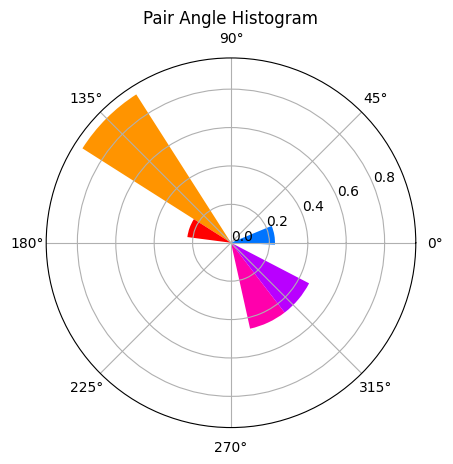

In [23]:
plot_latency_angle_hist(sd, good_pairs2)

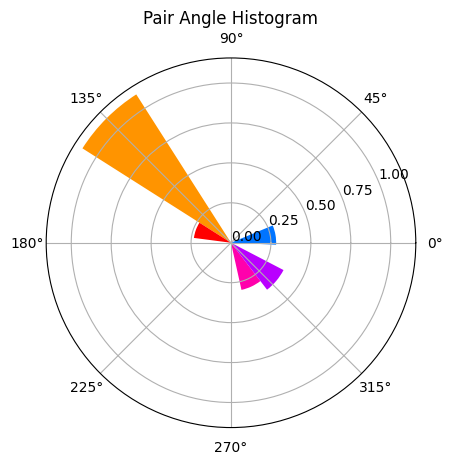

In [24]:
plot_latency_angle_hist(sd, good_pairs2, by_firing_rate=True)

# Vector plots

In [33]:
plot_vector_layout

<function human_hip.spike_data.plot_latencies.plot_vector_layout(sd, pairs, normalize=True, plot_neuron=True, arrow_length=75, min_dist=0, image_path=None, xlim=None, ylim=None, background_color='white')>

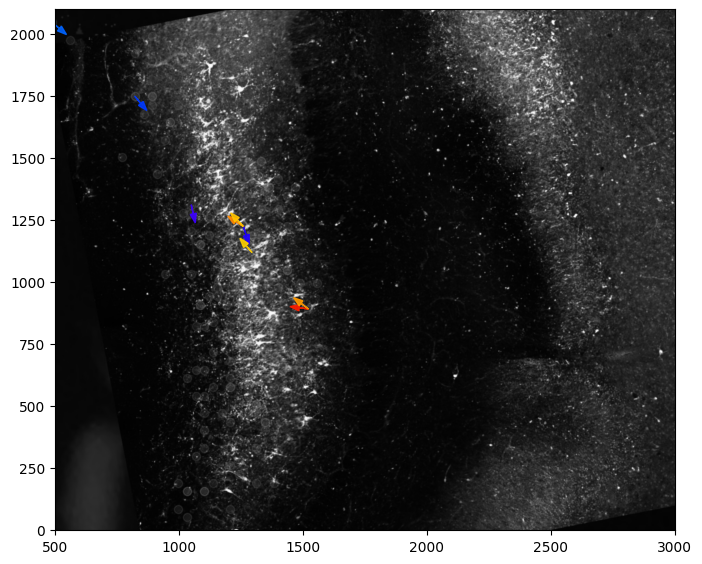

In [25]:
plot_vector_layout( sd, good_pairs2, image_path="/workspaces/human_hippocampus/data/histology/hc328_bw.jpeg", xlim=(500,3000) )

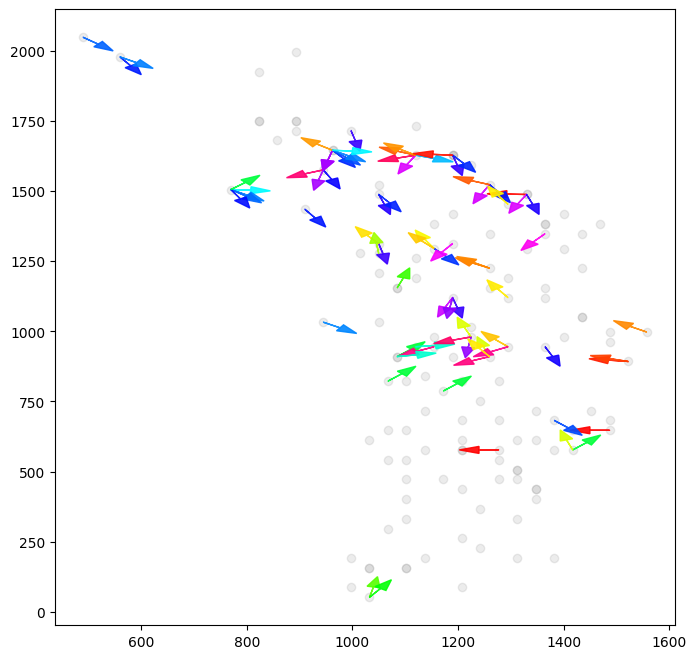

In [44]:
plot_vector_layout( sd, good_pairs)